In [2]:
import pandas as pd
import librosa as mimosa
import audioread
import os
import matplotlib as plt
import seaborn as sns
import numpy as np

musicGender = os.listdir("musics") # returns list
genderlabel = []
musicData = []

for gender in musicGender:
    genderMusics = os.listdir('./musics/{}'.format(gender))
    for music in genderMusics:
        genderlabel.append(gender)
        
        amplitude, sr = mimosa.load('./musics/{}'.format(gender)+'/{}'.format(music))

        melSpec = mimosa.feature.melspectrogram(y = amplitude, sr=sr, n_mels=128, fmax=8000)    
        melSpec_to_db = mimosa.power_to_db(melSpec, ref=np.max)
        resized_melSpec = np.resize(melSpec_to_db, (melSpec_to_db.shape[0], 1293))
        
        musicData.append(resized_melSpec)

mfcc_specData=np.stack(musicData)
musicData=np.array(musicData)
genderlabel=np.array(genderlabel)


In [57]:
# tempo = []

# for i, data in enumerate(musicData):
#     t, beat = mimosa.beat.beat_track(y=musicData[i])
#     print('{}'.format(t)+ " {}".format(i))
#     tempo.append(t)


In [58]:
# d = {'tempo': tempo, 'genderlabel':genderlabel}
# tempoDF = pd.DataFrame(data=d)

# for t in tempoDF:
#     print(tempoDF.index)

In [59]:
# sns.barplot(data=tempoDF, x="genderlabel"  ,y="tempo")

In [3]:
import sklearn.preprocessing as preProSkL

labelEncoder = preProSkL.LabelEncoder()
labelEncoded = labelEncoder.fit(genderlabel)
labelEncodedTrans = labelEncoded.transform(genderlabel)
# inverse_transform to revert to normal

In [61]:
# mfcc_specData = []

# for i, data in enumerate(musicData):
#     melSpec = mimosa.feature.melspectrogram(y = data)    
#     melSpec_to_db = mimosa.power_to_db(melSpec, ref=np.max)
#     mfcc_specData.append(melSpec_to_db)

# mfcc_specData=np.array(mfcc_specData)
# print(mfcc_specData)

In [4]:
# normalizar dados

from sklearn.preprocessing import StandardScaler

# sc_X=StandardScaler()
# mfcc_specData = sc_X.fit_transform(mfcc_specData)

# mfcc_specData.head()

mean = np.mean(mfcc_specData, axis=-1, keepdims=True)
std = np.std(mfcc_specData, axis=-1, keepdims=True)

# Normalize the array by subtracting the mean and dividing by the standard deviation
normalized_data = (mfcc_specData - mean) / std

print(len(normalized_data))


1000


In [63]:
# # Normalização Min Max

# print(labelEncodedTrans[0:100])
# print(mfcc_specData[99])
# print(mfcc_specData[100])
# print(mfcc_specData[101])

# indexMin=0
# indexMax = 99

# for genre in labelEncodedTrans[indexMin:indexMax]

# # xScaled = (xAtual - xMin) / (xMax - xMin)

In [9]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=42, shuffle=True)
for train, test in kf.split(normalized_data):
    print("%s %s" % (train, test))
    print( len(normalized_data[train]))
    print( len(normalized_data[test]))

# print(normalized_data[train])
X_train, X_test, y_train, y_test = normalized_data[train], normalized_data[test], labelEncodedTrans[train], labelEncodedTrans[test]

[  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  24  25  26  27  28  29  31  32  33  34  35  36  37  38
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  55  56  57  58
  60  61  62  64  65  68  69  71  72  73  74  75  77  78  79  80  81  82
  83  84  85  86  87  89  90  91  92  93  94  95  97  98  99 100 102 103
 104 105 106 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 137 138 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 199 200 201 202 203 204 205 206 207 208 211 212 213 214 215 216 217 219
 220 222 223 224 225 226 227 228 229 230 231 232 233 234 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 262 263 264 265 266 267 268 269 270 27

In [99]:
print(len(X_train))

900


In [64]:
# import sklearn.model_selection as modelSelec

# X_train, X_test, y_train, y_test = modelSelec.train_test_split(normalized_data, labelEncodedTrans, test_size=0.25, random_state=42)

# # X_train, X_test, y_val, y_val = modelSelec.train_test_split(mfcc_specData, labelEncodedTrans, test_size=0.5, random_state=42)
# X_test,X_validation,y_test,y_validation=modelSelec.train_test_split(X_test,y_test,test_size=0.2, random_state=42)


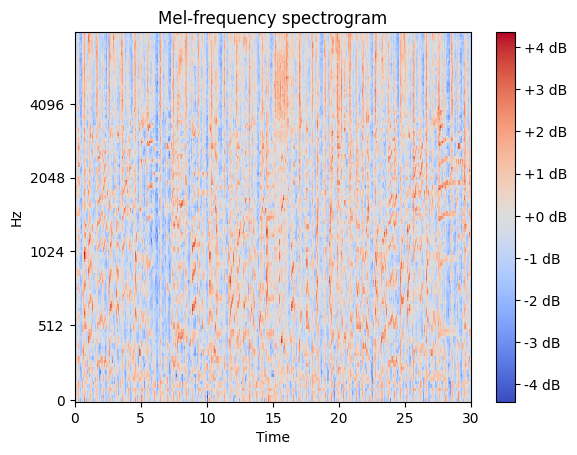

In [85]:
import matplotlib.pyplot as pyplot



fig, ax = pyplot.subplots()
img = mimosa.display.specshow(normalized_data[0], x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')

pyplot.savefig('0.png')

  

In [66]:
# import matplotlib.pyplot as pyplot

# musicCounter = 0

# path = './musicsPlts'
# if not os.path.exists(path):
#     os.mkdir(path)

# for gender in musicGender:
#     genderPath = '{}'.format(path) + '/{}'.format(gender)
#     if not os.path.exists(genderPath):
#         os.mkdir(genderPath)

# for index in range(len(mfcc_specData)):
#     fig, ax = pyplot.subplots()
#     img = mimosa.display.specshow(mfcc_specData[index], x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
#     fig.colorbar(img, ax=ax, format='%+2.0f dB')

#     ax.set(title='Mel-frequency spectrogram')

#     if index % 100 == 0:
#         musicCounter = 0
    
#     pyplot.savefig('{}'.format(path) + '/{}'.format(genderlabel[index]) + '/{}'.format(musicCounter) + '.png')

#     musicCounter +=1




In [100]:
print(X_train.shape)
input_shape=(X_train.shape[1],X_train.shape[2],1)
print(X_train.shape)
print(input_shape)


(900, 128, 1293)
(900, 128, 1293)
(128, 1293, 1)


In [101]:
from tensorflow import keras

model=keras.Sequential()
#1st layer
model.add(keras.layers.Conv2D(24,(3,3),activation="relu",input_shape=input_shape))
model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding="same")) 
model.add(keras.layers.BatchNormalization())

#2nd layer
model.add(keras.layers.Conv2D(24,(3,3),activation="relu"))
model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding="same")) #pooling
model.add(keras.layers.BatchNormalization())

#3rd layer
model.add(keras.layers.Conv2D(24,(2,2),activation="relu"))
model.add(keras.layers.MaxPool2D((2,2),strides=(2,2),padding="same")) #pooling
model.add(keras.layers.BatchNormalization())


#flatten the output
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(20,activation="relu"))
model.add(keras.layers.Dropout(0.2))

#output layer
model.add(keras.layers.Dense(10,activation="softmax"))

optimizer=keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'])


In [102]:
print(X_train.shape[0])
print(X_train.shape[0])
print(X_train.reshape((-1, X_train.shape[1], X_train.shape[2], 1)))

900
900
[[[[-0.67005205]
   [-0.6623049 ]
   [-1.109662  ]
   ...
   [-0.19242966]
   [ 0.05554507]
   [ 1.703001  ]]

  [[-1.1860182 ]
   [-0.734867  ]
   [-0.67481345]
   ...
   [-0.24824226]
   [ 0.29169312]
   [ 0.85158294]]

  [[-1.8743839 ]
   [-1.8484333 ]
   [-0.7604588 ]
   ...
   [-0.579359  ]
   [ 0.7662539 ]
   [ 0.7214715 ]]

  ...

  [[-1.6145535 ]
   [-1.0936167 ]
   [-0.6488527 ]
   ...
   [-1.0590883 ]
   [-0.7118242 ]
   [-0.63664466]]

  [[-1.9550405 ]
   [-1.3171382 ]
   [-0.6200165 ]
   ...
   [-1.50424   ]
   [-0.8369677 ]
   [-0.5747442 ]]

  [[-2.0235476 ]
   [-1.1735839 ]
   [-0.31622347]
   ...
   [-1.1365972 ]
   [-0.3782347 ]
   [-0.36212888]]]


 [[[ 0.2789221 ]
   [-0.01649575]
   [-0.62648153]
   ...
   [ 1.8037028 ]
   [ 1.3777665 ]
   [ 0.47642788]]

  [[ 0.27244294]
   [-0.05062367]
   [-0.54155743]
   ...
   [ 1.0010593 ]
   [ 0.49225202]
   [ 0.13203697]]

  [[ 0.4448628 ]
   [ 0.87084   ]
   [ 0.9664484 ]
   ...
   [ 0.12164785]
   [-0.19514105]
   

In [103]:
X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2], 1))
print(X_train.shape[0])
# history = model.fit(X_train,y_train,epochs=35, validation_data=(X_validation, y_validation))
history = model.fit(X_train,y_train,epochs=35, validation_data=(X_test, y_test))

900
Epoch 1/35
29/29 [==============================] - 56s 2s/step - loss: 2.3247 - accuracy: 0.2111 - val_loss: 2.3142 - val_accuracy: 0.0700
Epoch 2/35
29/29 [==============================] - 58s 2s/step - loss: 1.4403 - accuracy: 0.4844 - val_loss: 2.5592 - val_accuracy: 0.0900
Epoch 3/35
29/29 [==============================] - 64s 2s/step - loss: 1.0218 - accuracy: 0.6167 - val_loss: 3.0353 - val_accuracy: 0.0800
Epoch 4/35
29/29 [==============================] - 54s 2s/step - loss: 0.7655 - accuracy: 0.7044 - val_loss: 3.7754 - val_accuracy: 0.0800
Epoch 5/35
29/29 [==============================] - 54s 2s/step - loss: 0.5811 - accuracy: 0.7644 - val_loss: 4.2959 - val_accuracy: 0.0800
Epoch 6/35
29/29 [==============================] - 54s 2s/step - loss: 0.4378 - accuracy: 0.8333 - val_loss: 4.9042 - val_accuracy: 0.0800
Epoch 7/35
29/29 [==============================] - 54s 2s/step - loss: 0.3743 - accuracy: 0.8456 - val_loss: 4.9186 - val_accuracy: 0.0800
Epoch 8/35
29/29

KeyboardInterrupt: 

{'loss': [2.537238121032715, 1.331550121307373, 0.926496148109436, 0.6746801733970642, 0.43899282813072205, 0.31934839487075806, 0.2502688467502594, 0.2477719634771347, 0.19042234122753143, 0.1919446587562561, 0.2124977707862854, 0.18970967829227448, 0.14422151446342468, 0.1325674206018448, 0.11178383231163025, 0.0917416512966156, 0.07478900998830795, 0.09812452644109726, 0.0927841067314148, 0.09270496666431427, 0.09957490116357803, 0.08640437573194504, 0.08591503649950027, 0.090933658182621, 0.08821233361959457, 0.08122235536575317, 0.06894605606794357, 0.059654753655195236, 0.07602214813232422, 0.08488306403160095, 0.08726765215396881, 0.05484265461564064, 0.05471841245889664, 0.05109236761927605, 0.05123666673898697], 'accuracy': [0.18000000715255737, 0.5120000243186951, 0.6700000166893005, 0.7720000147819519, 0.8579999804496765, 0.906000018119812, 0.9120000004768372, 0.9259999990463257, 0.9399999976158142, 0.9340000152587891, 0.9300000071525574, 0.9440000057220459, 0.94800001382827

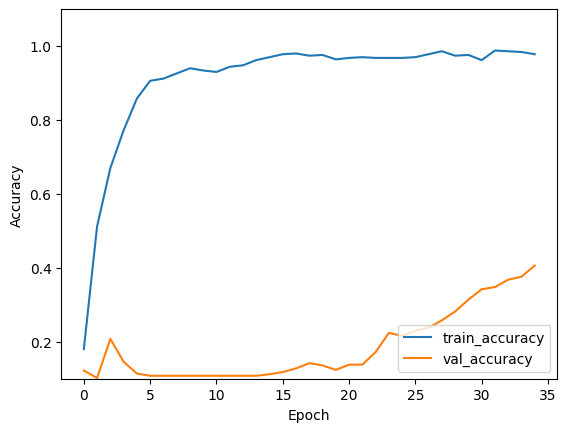

In [95]:
import matplotlib.pyplot as pyplot

print(history.history)

testError, testAccuracy = model.evaluate(X_test, y_test)
print("Accuracy on test set is:{}".format(testAccuracy))

pyplot.plot(history.history['accuracy'], label='train_accuracy')
pyplot.plot(history.history['val_accuracy'], label = 'val_accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.ylim([0.1, 1.1])
pyplot.legend(loc='lower right')

In [92]:
from sklearn.metrics import confusion_matrix

Y_previsto = model.predict(X_test)

cm = confusion_matrix(y_test,Y_previsto)

sns.heatmap(cm, annot=True, fmt="d")

16/16 [==============================] - 4s 241ms/step
[[4.19038236e-02 1.10244557e-01 5.93092859e-01 ... 6.60428405e-03
  1.10689692e-01 3.53032202e-02]
 [8.82282779e-02 1.00327106e-02 2.59375036e-01 ... 2.24086829e-02
  1.26311695e-02 1.50793090e-01]
 [1.43832028e-01 8.74419603e-03 4.89745773e-02 ... 1.50730612e-03
  5.93149196e-03 1.59442110e-03]
 ...
 [8.54727402e-02 2.18407088e-03 1.25165313e-01 ... 1.06204119e-04
  6.55402848e-03 1.30201196e-02]
 [2.44553566e-01 1.53117918e-03 5.76018631e-01 ... 1.30079500e-02
  2.61859852e-03 1.56758144e-01]
 [5.37080169e-01 3.64034437e-02 1.67332962e-01 ... 1.64132006e-03
  1.30473524e-01 9.41355675e-02]]


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets